In [1]:
from abc import ABC, abstractmethod
from collections import defaultdict
import math
import networkx as nx
import numpy as np
import os
import random
from matplotlib import pyplot as plt

In [2]:
class Node(ABC):
    """
    A representation of a single board state.
    MCTS works by constructing a tree of these Nodes.
    Could be e.g. a chess or checkers board state.
    """

    @abstractmethod
    def find_children(self):
        "All possible successors of this board state"
        return set()

    @abstractmethod
    def find_random_child(self):
        "Random successor of this board state (for more efficient simulation)"
        return None

    @abstractmethod
    def is_terminal(self):
        "Returns True if the node has no children"
        return True

In [3]:
#generate random graph of preset size
def generate_graph(vertices):
    return nx.generators.random_graphs.gnp_random_graph(vertices,
                np.random.uniform(0,0.5))

In [4]:
class VertexCoverInstance(Node):
    def __init__(self, graph, cover = [], reward = 0):
        self.graph = graph
        self.cover = cover
        self.reward = reward
        self.possible_moves = [node for node in list(graph.nodes) if graph.degree[node]]
        
    def find_children(self):
        possiblemoves = []
        possiblenodes = []
        if self.is_terminal():  # If the game is finished then no moves can be made
            return possiblemoves
        for i in list(self.graph.nodes):
            H = self.graph.copy()
            if H.degree[i]:
                step_reward = -1
                H.remove_node(i)
                H.add_node(i)
                possiblenodes.append(i)
                possiblemoves.append(VertexCoverInstance(H, self.cover+[i], self.reward+step_reward))
        return possiblemoves

    def find_children_with_actions(self):
        possiblemoves = []
        possiblenodes = []
        if self.is_terminal():  # If the game is finished then no moves can be made
            return (possiblenodes, possiblemoves)
        for i in list(self.graph.nodes):
            H = self.graph.copy()
            if H.degree[i]:
                step_reward = -1
                H.remove_node(i)
                H.add_node(i)
                possiblenodes.append(i)
                possiblemoves.append(VertexCoverInstance(H, self.cover+[i], self.reward+step_reward))
        return (possiblenodes, possiblemoves)
        
    
    def take_action(self, action):
        if self.is_terminal():
            raise IndexError("Terminal state cannot be acted upon")
        if action not in self.possible_moves:
            raise IndexError("This action is illegal")
        H = self.graph.copy()
        step_reward = -1
        H.remove_node(action)
        H.add_node(action)
        return VertexCoverInstance(H, self.cover+[action], self.reward+step_reward)

    def find_random_child(self):
        if self.is_terminal():
            return None  # If the game is finished then no moves can be made
        temp = self.find_children()
        return random.sample(set(temp),1)[0]

    def is_terminal(self):
        return nx.classes.function.is_empty(self.graph)

    def to_pretty_string(self):
        return str(list(self.graph.nodes()))
    
    def get_cover(self):
        return self.cover
    
    def get_reward(self):
        return self.reward
    

In [5]:
def play_game(G, display = True):
    tree = MCTS()
    board = VertexCoverInstance(G)
    #print(board.to_pretty_string())
    moves = 0
    while True:
        if board.is_terminal():
            break
        #80 rollouts per turn
        for _ in range(80):
            tree.do_rollout(board)
        board = tree.choose(board)
        #print(board.to_pretty_string())
        moves = moves+1
        if board.is_terminal():
            break
            
    vc = board.get_cover()
    if display:
        print("\n\nMCTS APPROX\n")
        print(vc)
        color_map = []
        for node in G:
            if node in vc:
                color_map.append('red')
            else: 
                color_map.append('blue')  
        plt.figure(1)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return vc

In [6]:
from networkx.algorithms import approximation as appx
import itertools

def show_optimal_vc(G, display=True):
    def findsubsets(s): 
        lists =[list(itertools.combinations(s, n)) for n in range(len(s))]
        return list(itertools.chain.from_iterable(lists))
    
    powerset = findsubsets(list(G.nodes()))    
    for s in powerset:
        H = G.copy()
        H.remove_nodes_from(s)
        if nx.classes.function.is_empty(H):
            opt = list(s)
            break
    if display:
        print("\n\nOPTIMAL\n")
        print(opt)
        color_map = []
        for node in G:
            if node in opt:
                color_map.append('orange')
            else: 
                color_map.append('green')
        plt.figure(2)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return opt

In [7]:
class MCTS_AZ:
    "Monte Carlo tree searcher with GNN. First rollout the tree then choose a move."

    def __init__(self, net, exploration_weight=1):
        self.Q = defaultdict(int)  # total reward of each node
        self.N = defaultdict(int)  # total visit count for each node
        self.children = dict()  # children of each node
        self.priors = dict() # prior probability of visiting each child of a given node
        self.exploration_weight = exploration_weight
        self.net = net

    def choose(self, node):
        "Choose the best successor of node. (Choose a move in the game)"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")

        if node not in self.children:
            return node.find_random_child()

        def score(n):
            if self.N[n] == 0:
                return float("-inf")  # avoid unseen moves
            return self.Q[n] / self.N[n]  # average reward

        return max(self.children[node], key=score)
    
    def choose_by_policy(self, node):
        "Choose a successor of node according to policy"
        if node.is_terminal():
            raise RuntimeError(f"choose called on terminal node {node}")
            
        if node not in self.children:
            return node.find_random_child()
        
        policy = list(map(lambda n: self.N[n]/(self.N[node]-1), self.children[node]))
        action = np.random.choice(len(policy), 1, p=policy)[0]
        successor = self.children[node][action]

        return successor,policy

    def do_rollout(self, node):
        "Make the tree one layer better. (Train for one iteration.)"
        path = self._select(node)
        leaf = path[-1]
        self._expand(leaf)
        reward = self._simulate(leaf)
        self._backpropagate(path, reward)

    def _select(self, node):
        "Find an unexplored descendent of `node`"
        path = []
        while True:
            path.append(node)
            if node not in self.children or not self.children[node]:
                # node is either unexplored or terminal
                return path
            for child in self.children[node]:
                if child not in self.children:
                    path.append(child)
                    return path
            node = self._uct_select(node)  # descend a layer deeper

    def _expand(self, node):
        "Update the `children` dict with the children of `node`"
        if node in self.children:
            return  # already expanded
        vertices, children = node.find_children_with_actions()
        self.children[node] = children
        if children:
            all_priors = self.net.predict(node)
            all_priors *= len(all_priors)
            self.priors[node] = [all_priors[i] for i in vertices]

    def _simulate(self, node):
        "Returns the reward for a random simulation (to completion) of `node`"
        reward = 0
        while True:
            if node.is_terminal():
                return reward
            node = node.find_random_child()
            reward = node.get_reward()

    def _backpropagate(self, path, reward):
        "Send the reward back up to the ancestors of the leaf"
        for node in reversed(path):
            self.N[node] += 1
            self.Q[node] += reward

    def _uct_select(self, node):
        "Select a child of node, balancing exploration & exploitation"

        # All children of node should already be expanded:
        assert all(n in self.children for n in self.children[node])

        def uct(n):
            "Upper confidence bound for trees"
            i,n = n # expand from enumerate tuple
            return self.Q[n] / self.N[n] + self.exploration_weight * self.priors[node][i] * math.sqrt(
                self.N[node] / self.N[n]
            )

        return max(enumerate(self.children[node]), key=uct)[1]

In [8]:
def play_game_AZ(G, net,num_rollouts=80, display = True, net_weight = 1):
    tree = MCTS_AZ(net, exploration_weight = net_weight)
    board = VertexCoverInstance(G)
    while True:
        if board.is_terminal():
            break
        for _ in range(num_rollouts):
            tree.do_rollout(board)
        board = tree.choose(board)
            
    vc = board.get_cover()
    if display:
        print("\n\nMCTS APPROX\n")
        print(vc)
        color_map = []
        for node in G:
            if node in vc:
                color_map.append('red')
            else: 
                color_map.append('blue')  
        plt.figure(1)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return vc

def play_game_net(G, net, display=True):
    board = VertexCoverInstance(G)
    while not board.is_terminal():
        pred_policy = net.predict(board)
        updated_policy = []
        count = 0
        for i in range(board.graph.number_of_nodes()):
            if i in board.possible_moves:
                updated_policy.append(pred_policy[count])
                count+=1
            else:
                updated_policy.append(0)
        
        action = updated_policy.index(max(updated_policy))
        board = board.take_action(action)
    vc = board.get_cover()
    
    if display:
        print("\n\nNNET APPROX\n")
        print(vc)
        color_map = []
        for node in G:
            if node in vc:
                color_map.append('red')
            else: 
                color_map.append('blue')  
        plt.figure(1)
        nx.draw(G, node_color=color_map, with_labels=True)
        
    return vc

In [9]:
def self_play(G, net, num_rollouts=80, net_weight = 1):
    tree = MCTS_AZ(net, exploration_weight = net_weight)
    board = VertexCoverInstance(G)
    init_vertices = board.graph.number_of_nodes()
    data = []
    while True:
        if board.is_terminal():
            break
        for _ in range(num_rollouts):
            tree.do_rollout(board)
        
        possibilities = board.possible_moves
        new_board, policy = tree.choose_by_policy(board)
        updated_policy = []
        count = 0
        for i in range(init_vertices):
            if i in possibilities:
                updated_policy.append(policy[count])
                count+=1
            else:
                updated_policy.append(0)
        
        record = from_networkx(board.graph)
        record.y = torch.tensor(updated_policy).reshape(1,-1)
        data.append(record)
        board = new_board 
        
    return data

In [10]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_networkx

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = GCNConv(1, 8)
        self.conv2 = GCNConv(8, 16)
        self.conv3 = GCNConv(16, 16)
        self.conv4 = GCNConv(16, 8)
        self.conv_prob = GCNConv(8, 1)

    # expects a torch_geometric Data object
    def forward(self, data):
        num_nodes = data.num_nodes
        x = torch.tensor([[1.0] for _ in range(num_nodes)], requires_grad=True)
        edge_index = data.edge_index
        x = self.conv1(x ,edge_index)
        x = F.relu(x)

        x = self.conv_prob(x, edge_index)
        if hasattr(data, 'batch'):
            num_nodes = len(list(filter(lambda x: x == 0, data.batch)))
        x = x.view(-1,num_nodes)
        
        return F.softmax(x, dim=1)
    
    def predict(self, instance):
        data = from_networkx(instance.graph)
        return self.forward(data).flatten().tolist()
        

In [12]:
from torch_geometric.data import DataLoader

TRAIN_GRAPH_SIZE = 10
TEST_GRAPH_SIZE = 10

NUM_ITERS = 10
NUM_SELF_GAMES = 200
NUM_EPOCHS = 10
NUM_EVAL_SIMS = 200

NETWORK_WEIGHT = 1

scores = []

net = Net()
optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
criterion=torch.nn.BCELoss()

for i in range(NUM_ITERS):
    print('Iteration %d' % (i))
    
    # get self-play records
    print("Getting self-play records")
    records = []
    for i in range(NUM_SELF_GAMES):
        A = generate_graph(TRAIN_GRAPH_SIZE)
        records.extend(self_play(A, net, num_rollouts = 50, net_weight = NETWORK_WEIGHT))
        if i % (NUM_SELF_GAMES/5) == (NUM_SELF_GAMES/5)-1:
            print("  Generated game %d" % (i+1))
    
    # training
    print("Training")
    data_loader = DataLoader(records, batch_size=256, shuffle=True)
    for epoch in range(NUM_EPOCHS):
        total_loss = 0
        num_batches = 0
        for batch in data_loader:
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(batch).reshape(batch.y.shape)
            targets = batch.y
            loss = criterion(outputs, targets)
            total_loss += loss.item()
            num_batches += 1
            loss.backward(retain_graph=True)
            optimizer.step()

        # print statistics
        if epoch % 2 == 0:
            print('Epoch %d loss: %.3f' %
                  (epoch, total_loss / num_batches))
    
    print("Evaluating")
    count_success = 0
    for x in range(NUM_EVAL_SIMS):
        A = generate_graph(TEST_GRAPH_SIZE)
        vc = play_game_AZ(A, net,display=False, net_weight = NETWORK_WEIGHT)
        opt = show_optimal_vc(A, display=False)
        if len(vc)<=len(opt)*1.1:
            count_success=count_success+1
    print('Score: %.3f' % (count_success / NUM_EVAL_SIMS))
    scores.append(count_success / NUM_EVAL_SIMS)


Iteration 0
Getting self-play records
  Generated game 40
  Generated game 80
  Generated game 120
  Generated game 160
  Generated game 200
Training
Epoch 0 loss: 0.327
Epoch 2 loss: 0.326
Epoch 4 loss: 0.326
Epoch 6 loss: 0.326
Epoch 8 loss: 0.326
Evaluating
Score: 0.930
Iteration 1
Getting self-play records
  Generated game 40
  Generated game 80
  Generated game 120
  Generated game 160
  Generated game 200
Training
Epoch 0 loss: 0.325
Epoch 2 loss: 0.325
Epoch 4 loss: 0.325
Epoch 6 loss: 0.325
Epoch 8 loss: 0.324
Evaluating
Score: 0.950
Iteration 2
Getting self-play records
  Generated game 40
  Generated game 80
  Generated game 120
  Generated game 160
  Generated game 200
Training
Epoch 0 loss: 0.324
Epoch 2 loss: 0.324
Epoch 4 loss: 0.324
Epoch 6 loss: 0.323
Epoch 8 loss: 0.323
Evaluating
Score: 0.950
Iteration 3
Getting self-play records
  Generated game 40
  Generated game 80
  Generated game 120
  Generated game 160
  Generated game 200
Training
Epoch 0 loss: 0.323
Epoch 2 

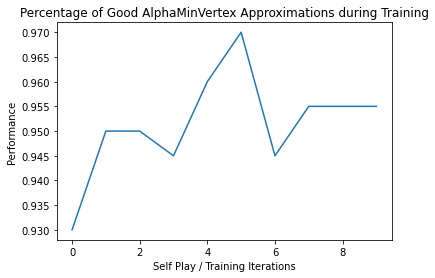

In [13]:
from matplotlib import pyplot as plt

plt.close()
plt.plot(scores)
plt.ylabel('Performance')
plt.xlabel('Self Play / Training Iterations')
plt.title('Percentage of Good AlphaMinVertex Approximations during Training')
plt.show()